<a href="https://colab.research.google.com/github/noahdanieldsouza/PAM-classification/blob/main/chart_positives.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchaudio numpy
!pip install git+https://github.com/google-research/perch-hoplite.git@782acd0e409eb27df51a695de4cb6608dae0db25

  Cloning https://github.com/google-research/perch-hoplite.git (to revision 782acd0e409eb27df51a695de4cb6608dae0db25) to /tmp/pip-req-build-pvlw48p7
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/perch-hoplite.git /tmp/pip-req-build-pvlw48p7
  Running command git rev-parse -q --verify 'sha^782acd0e409eb27df51a695de4cb6608dae0db25'
  Running command git fetch -q https://github.com/google-research/perch-hoplite.git 782acd0e409eb27df51a695de4cb6608dae0db25
  Running command git checkout -q 782acd0e409eb27df51a695de4cb6608dae0db25
  Resolved https://github.com/google-research/perch-hoplite.git to commit 782acd0e409eb27df51a695de4cb6608dae0db25
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61

In [4]:
import os
import torch
import torchaudio
import numpy as np
import csv
import gc
import tempfile

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

from perch_hoplite.agile import colab_utils, embed, source_info
from perch_hoplite.db import sqlite_usearch_impl
from perch_hoplite.zoo import model_configs
from perch_hoplite.agile.classifier import LinearClassifier

# --- Paths ---
db_path = '/content/drive/MyDrive/sept26/DB'
classifier_path = '/content/drive/MyDrive/full_labeled_fish/DB/agile_classifier_v2.pt'


# --- Load DB + model ---
db = sqlite_usearch_impl.SQLiteUsearchDB.create(db_path)
db_model_config = db.get_metadata('model_config')
model_class = model_configs.get_model_class(db_model_config['model_key'])
embedding_model = model_class.from_config(db_model_config['model_config'])
embedding_ids = db.get_embedding_ids()
print(f"✅ loaded {len(embedding_ids)} embeddings")
id = embedding_ids[0]
vector = db.get_embedding(id)
print(f"✅ vector {vector}")

# --- Load classifier ---
classifier = LinearClassifier.load(classifier_path)
class_names = classifier.classes
print("✅ Loaded classifier with classes:", class_names)

graph = []

for i in range(20):
  threshold = i * .05
  total = 0
  for emb_id in embedding_ids:
      print (f"processing embedding: {emb_id}")
      vector = db.get_embedding(emb_id)
      logits = classifier(vector)
      #print(f"✅ logits: {logits}")
      probs = np.exp(logits) / np.sum(np.exp(logits))
      #print(f"✅ probs: {probs}")
      pred_idx = np.argmax(probs)
      pred_label = class_names[pred_idx]
      confidence = probs[pred_idx]
      if confidence > threshold and pred_label != "boat":
        total +=1

  graph.append((threshold, total))




Streaming output truncated to the last 5000 lines.
processing embedding: 16601
processing embedding: 16602
processing embedding: 16603
processing embedding: 16604
processing embedding: 16605
processing embedding: 16606
processing embedding: 16607
processing embedding: 16608
processing embedding: 16609
processing embedding: 16610
processing embedding: 16611
processing embedding: 16612
processing embedding: 16613
processing embedding: 16614
processing embedding: 16615
processing embedding: 16616
processing embedding: 16617
processing embedding: 16618
processing embedding: 16619
processing embedding: 16620
processing embedding: 16621
processing embedding: 16622
processing embedding: 16623
processing embedding: 16624
processing embedding: 16625
processing embedding: 16626
processing embedding: 16627
processing embedding: 16628
processing embedding: 16629
processing embedding: 16630
processing embedding: 16631
processing embedding: 16632
processing embedding: 16633
processing embedding: 166

In [5]:
print(graph)

[(0.0, 17323), (0.05, 17323), (0.1, 17323), (0.15000000000000002, 17323), (0.2, 17265), (0.25, 14801), (0.30000000000000004, 9088), (0.35000000000000003, 4557), (0.4, 2080), (0.45, 874), (0.5, 312), (0.55, 111), (0.6000000000000001, 39), (0.65, 8), (0.7000000000000001, 1), (0.75, 0), (0.8, 0), (0.8500000000000001, 0), (0.9, 0), (0.9500000000000001, 0)]


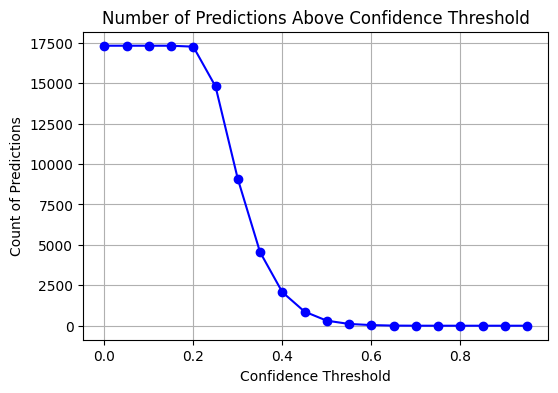

In [6]:
import matplotlib.pyplot as plt

# unzip the list of tuples into two lists
x_vals, y_vals = zip(*graph)

plt.figure(figsize=(6, 4))
plt.plot(x_vals, y_vals, marker='o', linestyle='-', color='b')
plt.title("Number of Predictions Above Confidence Threshold")
plt.xlabel("Confidence Threshold")
plt.ylabel("Count of Predictions")
plt.grid(True)
plt.show()
